## Connecting to a SQL Database

In [1]:
import os 
from dotenv import load_dotenv

load_dotenv()

#For Azure
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
OPENAI_API_VERSION = os.getenv("OPENAI_API_VERSION")
AZURE_DEPLOYMENT = os.getenv("AZURE_DEPLOYMENT")
AZURE_ENDPOINT = os.getenv("AZURE_ENDPOINT")

#For Openai
OPENAI_API_KEY= os.getenv("OPENAI_API_KEY")

## Setup

In [2]:
from IPython.display import Image

import os
from IPython.display import Markdown, HTML, display
from langchain.agents import create_sql_agent
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain.sql_database import SQLDatabase

# If using Azure:
from langchain_openai import AzureChatOpenAI
from langchain.chat_models import AzureChatOpenAI

# If using OpenAI:
from langchain_openai import ChatOpenAI

from sqlalchemy import create_engine

import pandas as pd



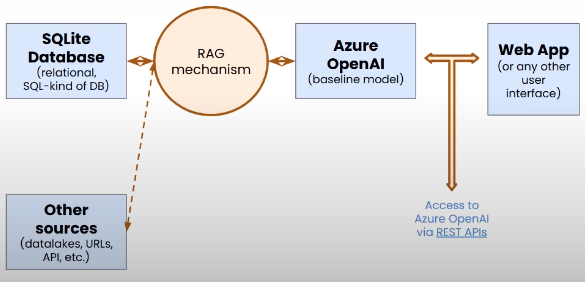

In [3]:


Image(filename='../assets/sql_agent.png', width=500)

**Note**: To access the data locally, use the following code:

```
os.makedirs("data",exist_ok=True)
!wget https://covidtracking.com/data/download/all-states-history.csv -P ./data/
file_url = "./data/all-states-history.csv"
df = pd.read_csv(file_url).fillna(value = 0)
```

## Move the data to an SQL Prompt:

In [4]:
# Path to your SQLite database file
database_file_path = "./db/test.db"

# Create an engine to connect to the SQLite database
# SQLite only requires the path to the database file
engine = create_engine(f'sqlite:///{database_file_path}')
file_url = "./data/all-states-history.csv"
df = pd.read_csv(file_url).fillna(value = 0)
df.to_sql(
    'all_states_history',
    con=engine,
    if_exists='replace',
    index=False
)

20780

## Build Prompt

In [5]:
MSSQL_AGENT_PREFIX = """

You are an agent designed to interact with a SQL database.
## Instructions:
- Given an input question, create a syntactically correct {dialect} query
to run, then look at the results of the query and return the answer.
- Unless the user specifies a specific number of examples they wish to
obtain, **ALWAYS** limit your query to at most {top_k} results.
- You can order the results by a relevant column to return the most
interesting examples in the database.
- Never query for all the columns from a specific table, only ask for
the relevant columns given the question.
- You have access to tools for interacting with the database.
- You MUST double check your query before executing it.If you get an error
while executing a query,rewrite the query and try again.
- DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.)
to the database.
- DO NOT MAKE UP AN ANSWER OR USE PRIOR KNOWLEDGE, ONLY USE THE RESULTS
OF THE CALCULATIONS YOU HAVE DONE.
- Your response should be in Markdown. However, **when running  a SQL Query
in "Action Input", do not include the markdown backticks**.
Those are only for formatting the response, not for executing the command.
- ALWAYS, as part of your final answer, explain how you got to the answer
on a section that starts with: "Explanation:". Include the SQL query as
part of the explanation section.
- If the question does not seem related to the database, just return
"I don\'t know" as the answer.
- Only use the below tools. Only use the information returned by the
below tools to construct your query and final answer.
- Do not make up table names, only use the tables returned by any of the
tools below.

## Tools:

"""

In [6]:
MSSQL_AGENT_FORMAT_INSTRUCTIONS = """

## Use the following format:

Question: the input question you must answer.
Thought: you should always think about what to do.
Action: the action to take, should be one of [{tool_names}].
Action Input: the input to the action.
Observation: the result of the action.
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer.
Final Answer: the final answer to the original input question.

Example of Final Answer:
<=== Beginning of example

Action: query_sql_db
Action Input: s
SELECT TOP (10) [death]
FROM covidtracking 
WHERE state = 'TX' AND date LIKE '2020%'

Observation:
[(27437.0,), (27088.0,), (26762.0,), (26521.0,), (26472.0,), (26421.0,), (26408.0,)]
Thought:I now know the final answer
Final Answer: There were 27437 people who died of covid in Texas in 2020.

Explanation:
I queried the `covidtracking` table for the `death` column where the state
is 'TX' and the date starts with '2020'. The query returned a list of tuples
with the number of deaths for each day in 2020. To answer the question,
I took the sum of all the deaths in the list, which is 27437.
I used the following query

```sql
SELECT [death] FROM covidtracking WHERE state = 'TX' AND date LIKE '2020%'"
```
===> End of Example

"""

In [ ]:
# For Azure
# llm = AzureChatOpenAI(
#     openai_api_version="2023-05-15",
#     azure_deployment="gpt-4-1106",
#     azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
#     temperature=0, 
#     max_tokens=500
# )

In [8]:
#For OpenAI directly
from langchain_openai import ChatOpenAI


model = ChatOpenAI(
    model_name="gpt-4",  
    openai_api_key=os.getenv("OPENAI_API_KEY"), 
    temperature=0,
    max_tokens=500,
)

In [9]:
db = SQLDatabase.from_uri(f"sqlite:///{database_file_path}")
toolkit = SQLDatabaseToolkit(db=db, llm=model)

In [10]:
QUESTION = """How may patients were hospitalized during October 2020
in New York, and nationwide as the total of all states?
Use the hospitalizedIncrease column
"""

agent_executor_SQL = create_sql_agent(
    prefix=MSSQL_AGENT_PREFIX,
    format_instructions=MSSQL_AGENT_FORMAT_INSTRUCTIONS,
    llm=model,
    toolkit=toolkit,
    top_k=30,
    verbose=True
)

# Invoke the Model

In [11]:
agent_executor_SQL.invoke(QUESTION)



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables
Action Input: ""all_states_historyThe table `all_states_history` seems to be the most relevant for this question. I should check its schema to see what columns it has.
Action: sql_db_schema
Action Input: all_states_history
CREATE TABLE all_states_history (
	date TEXT, 
	state TEXT, 
	death FLOAT, 
	"deathConfirmed" FLOAT, 
	"deathIncrease" BIGINT, 
	"deathProbable" FLOAT, 
	hospitalized FLOAT, 
	"hospitalizedCumulative" FLOAT, 
	"hospitalizedCurrently" FLOAT, 
	"hospitalizedIncrease" BIGINT, 
	"inIcuCumulative" FLOAT, 
	"inIcuCurrently" FLOAT, 
	negative FLOAT, 
	"negativeIncrease" BIGINT, 
	"negativeTestsAntibody" FLOAT, 
	"negativeTestsPeopleAntibody" FLOAT, 
	"negativeTestsViral" FLOAT, 
	"onVentilatorCumulative" FLOAT, 
	"onVentilatorCurrently" FLOAT, 
	positive FLOAT, 
	"positiveCasesViral" FLOAT, 
	"positiveIncrease" BIGINT, 
	"positiveScore" BIGINT, 
	"positiveTestsAntibody" FLOAT, 
	"positiveTestsAntigen" F

{'input': 'How may patients were hospitalized during October 2020\nin New York, and nationwide as the total of all states?\nUse the hospitalizedIncrease column\n',
 'output': "No patients were hospitalized in New York in October 2020, and 53485 patients were hospitalized nationwide.\n\nExplanation:\nI queried the `all_states_history` table for the sum of the `hospitalizedIncrease` column where the state is 'NY' and the date starts with '2020-10'. The query returned 0, which means no patients were hospitalized in New York in October 2020. I used the following query:\n\n```sql\nSELECT SUM(hospitalizedIncrease) FROM all_states_history WHERE state = 'NY' AND date LIKE '2020-10%'\n```\n\nThen I queried the `all_states_history` table for the sum of the `hospitalizedIncrease` column where the date starts with '2020-10'. The query returned 53485, which means 53485 patients were hospitalized in all states in October 2020. I used the following query:\n\n```sql\nSELECT SUM(hospitalizedIncrease) F